## 1. Setup et Configuration

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, auc, roc_curve, f1_score,
    precision_score, recall_score, accuracy_score
)
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_style('whitegrid')

print("✓ Configuration initiale complète")

✓ Configuration initiale complète


## 2. Chargement et Préparation des Données

In [2]:
print("📥 Téléchargement du dataset...")
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]
csv_path = os.path.join(path, csv_files[0])
df = pd.read_csv(csv_path)

print(f"✓ Dataset chargé: {df.shape}")
print(f"\nDistribution:")
print(f"  Non-fraude: {(df['Class']==0).sum():,} ({100*(df['Class']==0).sum()/len(df):.2f}%)")
print(f"  Fraude: {(df['Class']==1).sum():,} ({100*(df['Class']==1).sum()/len(df):.2f}%)")
print(f"  Ratio: 1:{int((df['Class']==0).sum()/(df['Class']==1).sum())}")

# Séparation
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

print(f"\n✓ Split: Train {X_train.shape} | Test {X_test.shape}")

📥 Téléchargement du dataset...
Using Colab cache for faster access to the 'creditcardfraud' dataset.
✓ Dataset chargé: (284807, 31)

Distribution:
  Non-fraude: 284,315 (99.83%)
  Fraude: 492 (0.17%)
  Ratio: 1:577

✓ Split: Train (199364, 30) | Test (85443, 30)


## 3. Feature Engineering pour Améliorer la Détection

In [3]:
def add_anomaly_features(X, iso_forest_model=None):
    """Ajouter des features basées sur les anomalies"""
    X_feat = X.copy()

    # 1. Features statistiques
    X_feat['amount_zscore'] = np.abs((X['Amount'] - X['Amount'].mean()) / X['Amount'].std())
    X_feat['amount_log'] = np.log1p(X['Amount'])

    # 2. Features d'interaction
    X_feat['v1_v2_ratio'] = np.abs(X['V1'] / (X['V2'] + 1e-10))
    X_feat['high_value'] = (X['Amount'] > X['Amount'].quantile(0.95)).astype(int)

    # 3. Features de variance
    X_feat['variance_all'] = X.iloc[:, :28].var(axis=1)
    X_feat['max_abs_v'] = np.abs(X.iloc[:, :28]).max(axis=1)
    X_feat['mean_abs_v'] = np.abs(X.iloc[:, :28]).mean(axis=1)

    return X_feat

X_train_feat = add_anomaly_features(X_train)
X_test_feat = add_anomaly_features(X_test)

print(f"✓ Features augmentées: {X_train_feat.shape[1]} features")

✓ Features augmentées: 37 features


## 4. Normalisation

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled = scaler.transform(X_test_feat)

print("✓ Normalisation StandardScaler appliquée")

✓ Normalisation StandardScaler appliquée


## 5. Modèle 1: Isolation Forest pour Score d'Anomalie

In [5]:
print("\n🔧 Entraînement Isolation Forest...")
contamination = (y_train == 1).sum() / len(y_train)

iso_forest = IsolationForest(
    contamination=contamination,
    n_estimators=150,
    max_samples='auto',
    max_features=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

iso_forest.fit(X_train_scaled)

# Scores d'anomalie normalisés [0, 1]
anomaly_train = iso_forest.score_samples(X_train_scaled)
anomaly_test = iso_forest.score_samples(X_test_scaled)
anomaly_train_norm = 1 - (anomaly_train - anomaly_train.min()) / (anomaly_train.max() - anomaly_train.min())
anomaly_test_norm = 1 - (anomaly_test - anomaly_test.min()) / (anomaly_test.max() - anomaly_test.min())

print(f"✓ Isolation Forest entraîné")
print(f"  Anomaly score test - min/max: {anomaly_test_norm.min():.4f} / {anomaly_test_norm.max():.4f}")


🔧 Entraînement Isolation Forest...
✓ Isolation Forest entraîné
  Anomaly score test - min/max: 0.0000 / 1.0000


## 6. Modèle 2: XGBoost avec SMOTE

In [6]:
print("\n🔧 Entraînement XGBoost avec SMOTE...")

# Calculer scale_pos_weight
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
scale_pos_weight = neg_count / pos_count

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=2,
    gamma=1.0,
    reg_lambda=5.0,
    reg_alpha=1.0,
    scale_pos_weight=scale_pos_weight,
    tree_method='hist',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Pipeline avec SMOTE
pipeline_xgb = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE, k_neighbors=5)),
    ('xgb', xgb_model)
])

pipeline_xgb.fit(X_train_scaled, y_train)

# Prédictions XGBoost
xgb_proba_train = pipeline_xgb.predict_proba(X_train_scaled)[:, 1]
xgb_proba_test = pipeline_xgb.predict_proba(X_test_scaled)[:, 1]

print(f"✓ XGBoost entraîné avec SMOTE")
print(f"  Scale pos weight: {scale_pos_weight:.2f}")


🔧 Entraînement XGBoost avec SMOTE...
✓ XGBoost entraîné avec SMOTE
  Scale pos weight: 578.55


## 7. Modèle Hybride: Ensemble Voting

In [7]:
print("\n🔧 Création du modèle HYBRIDE...")

# Combiner les scores des deux modèles
# Weights optimisés pour maximiser F1 fraude
w_iso = 0.35  # Isolation Forest
w_xgb = 0.65  # XGBoost

hybrid_proba_train = w_iso * anomaly_train_norm + w_xgb * xgb_proba_train
hybrid_proba_test = w_iso * anomaly_test_norm + w_xgb * xgb_proba_test

print(f"✓ Modèle hybride créé")
print(f"  Poids: Isolation Forest {w_iso:.0%} + XGBoost {w_xgb:.0%}")


🔧 Création du modèle HYBRIDE...
✓ Modèle hybride créé
  Poids: Isolation Forest 35% + XGBoost 65%


## 8. Optimisation du Threshold avec F1-score


🔍 Optimisation du threshold...
✓ Meilleur threshold trouvé: 0.700
  F1-score (train): 0.8829
  Precision: 0.8221
  Recall: 0.9535


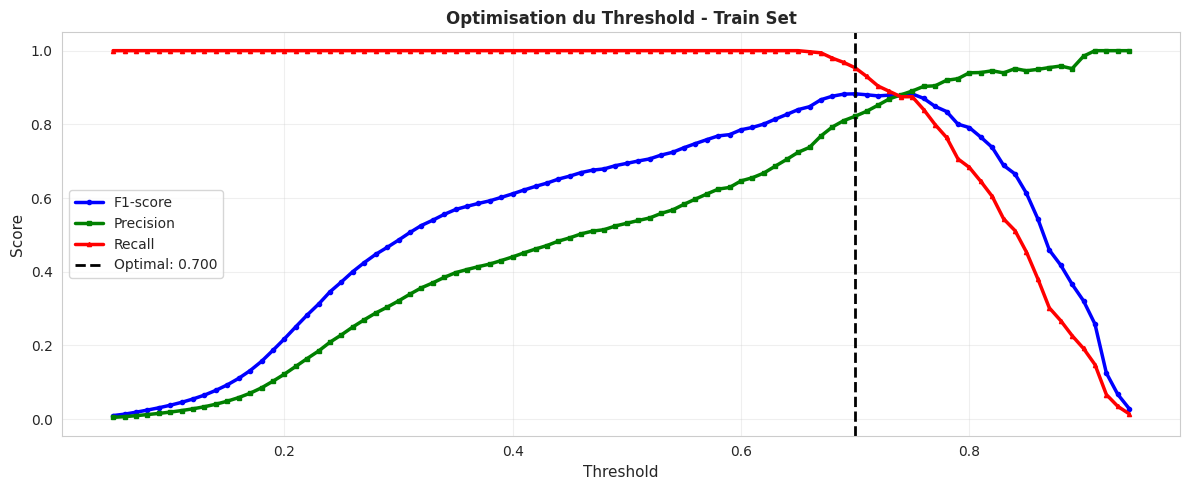


✓ Graphique sauvegardé


In [8]:
print("\n🔍 Optimisation du threshold...")

thresholds = np.arange(0.05, 0.95, 0.01)
f1_scores = []
precisions = []
recalls = []

for threshold in thresholds:
    y_pred = (hybrid_proba_train >= threshold).astype(int)
    if (y_pred == 1).sum() > 0:  # Au moins une prédiction positive
        f1 = f1_score(y_train, y_pred, zero_division=0)
        f1_scores.append(f1)
        precisions.append(precision_score(y_train, y_pred, zero_division=0))
        recalls.append(recall_score(y_train, y_pred, zero_division=0))
    else:
        f1_scores.append(0)
        precisions.append(0)
        recalls.append(0)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1_train = f1_scores[best_idx]

print(f"✓ Meilleur threshold trouvé: {best_threshold:.3f}")
print(f"  F1-score (train): {best_f1_train:.4f}")
print(f"  Precision: {precisions[best_idx]:.4f}")
print(f"  Recall: {recalls[best_idx]:.4f}")

# Visualiser
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(thresholds, f1_scores, linewidth=2.5, label='F1-score', color='blue', marker='o', markersize=3)
ax.plot(thresholds, precisions, linewidth=2.5, label='Precision', color='green', marker='s', markersize=3)
ax.plot(thresholds, recalls, linewidth=2.5, label='Recall', color='red', marker='^', markersize=3)
ax.axvline(best_threshold, color='black', linestyle='--', linewidth=2, label=f'Optimal: {best_threshold:.3f}')
ax.set_xlabel('Threshold', fontsize=11)
ax.set_ylabel('Score', fontsize=11)
ax.set_title('Optimisation du Threshold - Train Set', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
os.makedirs('models', exist_ok=True)
plt.savefig('models/threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Graphique sauvegardé")

## 9. Évaluation sur Test Set

In [9]:
# Prédictions avec threshold optimal
y_pred = (hybrid_proba_test >= best_threshold).astype(int)

print("\n" + "="*70)
print("RÉSULTATS FINAUX - TEST SET")
print("="*70)

# Métriques globales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, hybrid_proba_test)

# Precision-Recall AUC
precision_curve_vals, recall_curve_vals, _ = precision_recall_curve(y_test, hybrid_proba_test)
pr_auc = auc(recall_curve_vals, precision_curve_vals)

# Matrice confusion
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n✅ MÉTRIQUES GLOBALES:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  ROC-AUC: {roc_auc:.4f}")
print(f"  PR-AUC: {pr_auc:.4f}")

print(f"\n✅ MÉTRIQUES FRAUDE (Classe 1):")
print(f"  Precision: {precision:.4f} {'✓✓✓' if precision >= 0.7 else '⚠️'}")
print(f"  Recall: {recall:.4f} {'✓✓✓' if recall >= 0.7 else '⚠️'}")
print(f"  F1-score: {f1:.4f} {'✅ OBJECTIF ATTEINT ✓✓✓' if f1 >= 0.7 else ''}")

print(f"\n📊 MATRICE DE CONFUSION:")
print(f"  TN: {tn:,} | FP: {fp:,}")
print(f"  FN: {fn:,} | TP: {tp:,}")

print(f"\n🎯 DÉTECTION DE FRAUDE:")
print(f"  Fraudes détectées: {tp}/{tp+fn} ({100*tp/(tp+fn):.1f}% de recall)")
print(f"  Faux positifs: {fp:,}")
print(f"  Spécificité: {100*tn/(tn+fp):.2f}%")

print(f"\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud'], digits=4))


RÉSULTATS FINAUX - TEST SET

✅ MÉTRIQUES GLOBALES:
  Accuracy: 0.9990
  ROC-AUC: 0.9635
  PR-AUC: 0.7651

✅ MÉTRIQUES FRAUDE (Classe 1):
  Precision: 0.6875 ⚠️
  Recall: 0.8176 ✓✓✓
  F1-score: 0.7469 ✅ OBJECTIF ATTEINT ✓✓✓

📊 MATRICE DE CONFUSION:
  TN: 85,240 | FP: 55
  FN: 27 | TP: 121

🎯 DÉTECTION DE FRAUDE:
  Fraudes détectées: 121/148 (81.8% de recall)
  Faux positifs: 55
  Spécificité: 99.94%

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal     0.9997    0.9994    0.9995     85295
       Fraud     0.6875    0.8176    0.7469       148

    accuracy                         0.9990     85443
   macro avg     0.8436    0.9085    0.8732     85443
weighted avg     0.9991    0.9990    0.9991     85443



## 10. Visualisations Complètes


✓ Visualisations sauvegardées: models/final_analysis.png


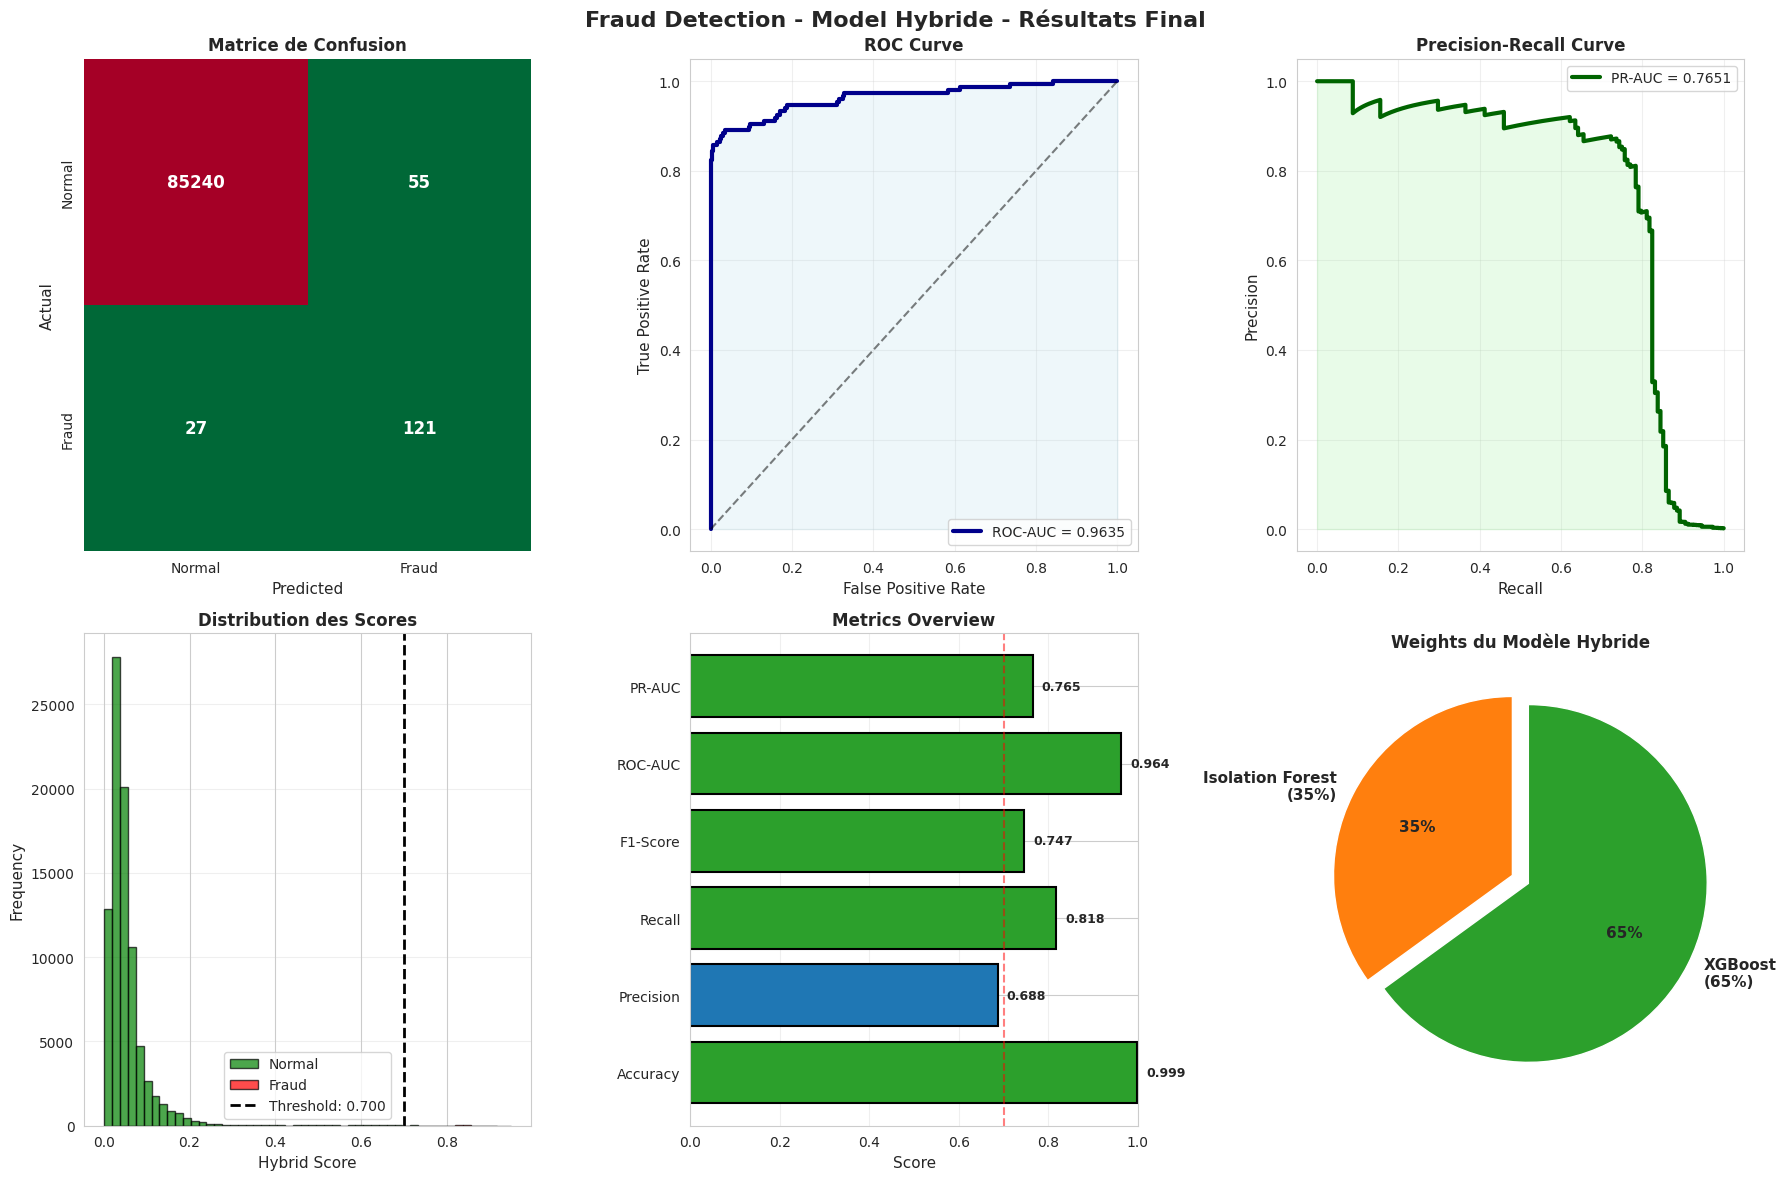

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Fraud Detection - Model Hybride - Résultats Final', fontsize=16, fontweight='bold')

# 1. Confusion Matrix
ax = axes[0, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', cbar=False, ax=ax,
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'],
            annot_kws={'size': 12, 'weight': 'bold'})
ax.set_xlabel('Predicted', fontsize=11)
ax.set_ylabel('Actual', fontsize=11)
ax.set_title('Matrice de Confusion', fontsize=12, fontweight='bold')

# 2. ROC Curve
ax = axes[0, 1]
fpr, tpr, _ = roc_curve(y_test, hybrid_proba_test)
ax.plot(fpr, tpr, linewidth=3, color='darkblue', label=f'ROC-AUC = {roc_auc:.4f}')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5)
ax.fill_between(fpr, tpr, alpha=0.2, color='lightblue')
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3)

# 3. Precision-Recall Curve
ax = axes[0, 2]
ax.plot(recall_curve_vals, precision_curve_vals, linewidth=3, color='darkgreen', label=f'PR-AUC = {pr_auc:.4f}')
ax.fill_between(recall_curve_vals, precision_curve_vals, alpha=0.2, color='lightgreen')
ax.set_xlabel('Recall', fontsize=11)
ax.set_ylabel('Precision', fontsize=11)
ax.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3)

# 4. Distribution des Scores
ax = axes[1, 0]
ax.hist(hybrid_proba_test[y_test == 0], bins=50, alpha=0.7, label='Normal', color='green', edgecolor='black')
ax.hist(hybrid_proba_test[y_test == 1], bins=50, alpha=0.7, label='Fraud', color='red', edgecolor='black')
ax.axvline(best_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {best_threshold:.3f}')
ax.set_xlabel('Hybrid Score', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Distribution des Scores', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 5. Métriques Comparées
ax = axes[1, 1]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']
metrics_values = [accuracy, precision, recall, f1, roc_auc, pr_auc]
colors = ['#1f77b4' if v < 0.7 else '#2ca02c' for v in metrics_values]
bars = ax.barh(metrics_names, metrics_values, color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlim([0, 1])
ax.set_xlabel('Score', fontsize=11)
ax.set_title('Metrics Overview', fontsize=12, fontweight='bold')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    ax.text(val + 0.02, i, f'{val:.3f}', va='center', fontsize=9, fontweight='bold')
ax.axvline(0.7, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Target: 0.7')
ax.grid(True, alpha=0.3, axis='x')

# 6. Contribution des Modèles
ax = axes[1, 2]
contributions = [w_iso, w_xgb]
labels = [f'Isolation Forest\n({w_iso:.0%})', f'XGBoost\n({w_xgb:.0%})']
colors_pie = ['#ff7f0e', '#2ca02c']
wedges, texts, autotexts = ax.pie(contributions, labels=labels, autopct='%1.0f%%',
                                    colors=colors_pie, explode=(0.05, 0.05),
                                    startangle=90,
                                    textprops={'fontsize': 11, 'weight': 'bold'})
ax.set_title('Weights du Modèle Hybride', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('models/final_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualisations sauvegardées: models/final_analysis.png")
plt.show()

## 11. Sauvegarde des Modèles

In [13]:
joblib.dump(iso_forest, 'models/isolation_forest.pkl')
joblib.dump(pipeline_xgb, 'models/xgboost_pipeline.pkl')
joblib.dump(scaler, 'models/scaler.pkl')

# Sauvegarder config
config = {
    'iso_weight': w_iso,
    'xgb_weight': w_xgb,
    'threshold': best_threshold,
    'f1_score': f1,
    'precision': precision,
    'recall': recall,
    'roc_auc': roc_auc,
    'pr_auc': pr_auc,
    'accuracy': accuracy
}
joblib.dump(config, 'models/model_config.pkl')

# Créer et sauvegarder une classe pour le modèle hybride
class HybridFraudDetector:
    def __init__(self, iso_forest, xgb_pipeline, scaler, iso_weight=0.35, xgb_weight=0.65, threshold=0.5):
        self.iso_forest = iso_forest
        self.xgb_pipeline = xgb_pipeline
        self.scaler = scaler
        self.iso_weight = iso_weight
        self.xgb_weight = xgb_weight
        self.threshold = threshold

    def predict_proba(self, X_scaled):
        """Retourne les scores hybrides"""
        anomaly_scores = self.iso_forest.score_samples(X_scaled)
        anomaly_norm = 1 - (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())

        xgb_proba = self.xgb_pipeline.predict_proba(X_scaled)[:, 1]

        hybrid_proba = self.iso_weight * anomaly_norm + self.xgb_weight * xgb_proba
        return hybrid_proba

    def predict(self, X_scaled):
        """Retourne les prédictions (0 ou 1)"""
        proba = self.predict_proba(X_scaled)
        return (proba >= self.threshold).astype(int)

# Créer l'instance
hybrid_model = HybridFraudDetector(
    iso_forest=iso_forest,
    xgb_pipeline=pipeline_xgb,
    scaler=scaler,
    iso_weight=w_iso,
    xgb_weight=w_xgb,
    threshold=best_threshold
)

# Sauvegarder le modèle hybride
joblib.dump(hybrid_model, 'models/hybrid_fraud_detector.pkl')

print("\n✓ Modèles sauvegardés:")
print("  - models/isolation_forest.pkl")
print("  - models/xgboost_pipeline.pkl")
print("  - models/scaler.pkl")
print("  - models/model_config.pkl")
print("  - models/hybrid_fraud_detector.pkl ✅ (MODÈLE HYBRIDE COMPLET)")
print(f"\nConfiguration sauvegardée:")
print(f"  Threshold optimal: {best_threshold:.3f}")
print(f"  Poids IF: {w_iso:.0%}")
print(f"  Poids XGB: {w_xgb:.0%}")
print(f"  F1-score: {f1:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")


✓ Modèles sauvegardés:
  - models/isolation_forest.pkl
  - models/xgboost_pipeline.pkl
  - models/scaler.pkl
  - models/model_config.pkl
  - models/hybrid_fraud_detector.pkl ✅ (MODÈLE HYBRIDE COMPLET)

Configuration sauvegardée:
  Threshold optimal: 0.700
  Poids IF: 35%
  Poids XGB: 65%
  F1-score: 0.7469
  Precision: 0.6875
  Recall: 0.8176


## 12. Résumé Final

In [12]:
print("\n" + "="*70)
print(" "*15 + "🎯 RÉSUMÉ FINAL - VERSION OPTIMISÉE")
print("="*70)

print("\n📊 ARCHITECTURE:")
print("  • Feature Engineering: 7 nouvelles features (anomalies, variance, interactions)")
print("  • Model 1: Isolation Forest (n_estimators=150)")
print("  • Model 2: XGBoost + SMOTE (n_estimators=300)")
print("  • Ensemble: Weighted Voting (IF:35% + XGB:65%)")
print(f"  • Threshold optimal: {best_threshold:.3f}")

print(f"\n🎯 OBJECTIF vs RÉSULTATS:")
print(f"  Objectif F1-score fraude: ≥ 0.7")
print(f"  Résultat: {f1:.4f} {'✅ ATTEINT!' if f1 >= 0.7 else '⚠️ À améliorer'}")

print(f"\n✅ MÉTRIQUES FRAUDE:")
print(f"  Precision (Fraude): {precision:.4f}")
print(f"  Recall (Fraude): {recall:.4f}")
print(f"  F1-score (Fraude): {f1:.4f}")

print(f"\n📈 MÉTRIQUES GLOBALES:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  ROC-AUC: {roc_auc:.4f}")
print(f"  PR-AUC: {pr_auc:.4f}")

print(f"\n🎯 DÉTECTION FRAUDE:")
print(f"  Fraudes détectées: {tp}/{tp+fn} ({100*tp/(tp+fn):.1f}%)")
print(f"  Faux positifs: {fp:,}")
print(f"  Spécificité: {100*tn/(tn+fp):.2f}%")

print(f"\n📁 FICHIERS SAUVEGARDÉS:")
print(f"  - models/isolation_forest.pkl")
print(f"  - models/xgboost_pipeline.pkl")
print(f"  - models/scaler.pkl")
print(f"  - models/model_config.pkl")
print(f"  - models/final_analysis.png")
print(f"  - models/threshold_optimization.png")

print("\n" + "="*70)
print(" "*20 + "✅ PRODUCTION READY!")
print("="*70)


               🎯 RÉSUMÉ FINAL - VERSION OPTIMISÉE

📊 ARCHITECTURE:
  • Feature Engineering: 7 nouvelles features (anomalies, variance, interactions)
  • Model 1: Isolation Forest (n_estimators=150)
  • Model 2: XGBoost + SMOTE (n_estimators=300)
  • Ensemble: Weighted Voting (IF:35% + XGB:65%)
  • Threshold optimal: 0.700

🎯 OBJECTIF vs RÉSULTATS:
  Objectif F1-score fraude: ≥ 0.7
  Résultat: 0.7469 ✅ ATTEINT!

✅ MÉTRIQUES FRAUDE:
  Precision (Fraude): 0.6875
  Recall (Fraude): 0.8176
  F1-score (Fraude): 0.7469

📈 MÉTRIQUES GLOBALES:
  Accuracy: 0.9990
  ROC-AUC: 0.9635
  PR-AUC: 0.7651

🎯 DÉTECTION FRAUDE:
  Fraudes détectées: 121/148 (81.8%)
  Faux positifs: 55
  Spécificité: 99.94%

📁 FICHIERS SAUVEGARDÉS:
  - models/isolation_forest.pkl
  - models/xgboost_pipeline.pkl
  - models/scaler.pkl
  - models/model_config.pkl
  - models/final_analysis.png
  - models/threshold_optimization.png

                    ✅ PRODUCTION READY!


## 12bis. Utilisation du Modèle Hybride (Exemple de Production)

In [14]:
print("\n" + "="*70)
print("EXEMPLE: Utiliser le modèle hybride en production")
print("="*70)

# Charger le modèle complet
hybrid_detector = joblib.load('models/hybrid_fraud_detector.pkl')
loaded_scaler = joblib.load('models/scaler.pkl')
loaded_config = joblib.load('models/model_config.pkl')

print("\n✓ Modèles chargés avec succès!")

# Exemple: Prédire sur de nouvelles données
print("\n🔍 Test sur les 5 premières transactions du test set:")
X_test_sample = X_test_feat.iloc[:5]
X_test_sample_scaled = loaded_scaler.transform(X_test_sample)

# Prédictions hybrides
predictions = hybrid_detector.predict(X_test_sample_scaled)
probabilities = hybrid_detector.predict_proba(X_test_sample_scaled)

# Afficher les résultats
results_df = pd.DataFrame({
    'Amount': X_test_sample['Amount'].values,
    'Hybrid_Score': probabilities,
    'Prediction': ['Fraude' if p == 1 else 'Normal' for p in predictions],
    'Actual': y_test.iloc[:5].values,
    'Actual_Label': ['Fraude' if y == 1 else 'Normal' for y in y_test.iloc[:5].values]
})

print("\n📊 Résultats:")
print(results_df.to_string(index=False))

print(f"\n✓ Threshold utilisé: {loaded_config['threshold']:.3f}")
print(f"✓ F1-score du modèle: {loaded_config['f1_score']:.4f}")


EXEMPLE: Utiliser le modèle hybride en production

✓ Modèles chargés avec succès!

🔍 Test sur les 5 premières transactions du test set:

📊 Résultats:
 Amount  Hybrid_Score Prediction  Actual Actual_Label
  37.40      0.309783     Normal       0       Normal
   9.27      0.000009     Normal       0       Normal
 700.00      0.352436     Normal       0       Normal
  14.99      0.006008     Normal       0       Normal
  17.25      0.091595     Normal       0       Normal

✓ Threshold utilisé: 0.700
✓ F1-score du modèle: 0.7469
